In [1]:
import os
import functools
import operator
import concurrent.futures

In [2]:
import h5py
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
import lib

In [4]:
lib.plotting.setup()

In [5]:
onecolumn_kwargs = {
    "width": 2,
    "height": 2,
    "horizontal_margin": 8/12,
    "vertical_margin": 6/12,
    "gutter": 1,
    "fig_width": 3 + 4/12,
    "fig_height": 3,
}
twocolumn_kwargs = {
    "width": 2,
    "height": 2,
    "horizontal_margin": 8/12,
    "vertical_margin": 6/12,
    "horizontal_gutter": 1 + 8/12,
    "fig_width": 7,
    "fig_height": 6,
}

In [6]:
shear_step_plus = "g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"
shear_step_minus = "g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"

assert shear_step_plus in lib.const.SHEAR_STEPS
assert shear_step_minus in lib.const.SHEAR_STEPS

In [7]:
 with (
        h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step_plus], "r") as shear_sim_plus,
        h5py.File(lib.const.SIM_REDSHIFT_CATALOGS[shear_step_plus], "r") as redshift_sim_plus,
        h5py.File(lib.const.SIM_WEIGHT_CATALOGS[shear_step_plus], "r") as weight_plus,
        h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step_minus], "r") as shear_sim_minus,
        h5py.File(lib.const.SIM_REDSHIFT_CATALOGS[shear_step_minus], "r") as redshift_sim_minus,
        h5py.File(lib.const.SIM_WEIGHT_CATALOGS[shear_step_minus], "r") as weight_minus,
        h5py.File(lib.const.Y6_SHEAR_CATALOG, "r") as shear_y6,
        h5py.File(lib.const.Y6_REDSHIFT_CATALOG, "r") as redshift_y6,
    ):
        mdet_step = "noshear"
            
        cell_sim_plus = lib.tomography.get_assignment(shear_sim_plus, redshift_sim_plus, mdet_step)
        statistical_weight_plus = weight_plus["mdet"]["noshear"]["statistical_weight"][:]
        nz_match_plus = weight_plus["mdet"]["noshear"]["nz_weight"][:]
        w_match_plus = weight_plus["mdet"]["noshear"]["occupancy_weight"][:]
        nbr_match_plus = weight_plus["mdet"]["noshear"]["neighbor_weight"][:]

            
        cell_sim_minus = lib.tomography.get_assignment(shear_sim_minus, redshift_sim_minus, mdet_step)
        statistical_weight_minus = weight_minus["mdet"]["noshear"]["statistical_weight"][:]
        nz_match_minus = weight_minus["mdet"]["noshear"]["nz_weight"][:]
        w_match_minus = weight_minus["mdet"]["noshear"]["occupancy_weight"][:]
        nbr_match_minus = weight_minus["mdet"]["noshear"]["neighbor_weight"][:]
        
        cell_y6 = lib.tomography.get_assignment(shear_y6, redshift_y6, mdet_step)
        weight_y6 = lib.weight.get_shear_weights(shear_y6["mdet"][mdet_step])

        # ---

        _som_weight_sim_plus, _, _ = stats.binned_statistic(
            cell_sim_plus,
            statistical_weight_plus,
            statistic="sum",
            bins=lib.const.CELL_IDS,
        )
        som_occupancy_sim_plus = _som_weight_sim_plus / sum(_som_weight_sim_plus)

        _som_weight_sim_minus, _, _ = stats.binned_statistic(
            cell_sim_minus,
            statistical_weight_minus,
            statistic="sum",
            bins=lib.const.CELL_IDS,
        )
        som_occupancy_sim_minus = _som_weight_sim_minus / sum(_som_weight_sim_minus)

        som_occupancy_sim = (som_occupancy_sim_plus + som_occupancy_sim_minus) / 2

        # ---
            
        _som_w_sim_plus, _, _ = stats.binned_statistic(
            cell_sim_plus,
            statistical_weight_plus * w_match_plus,
            statistic="sum",
            bins=lib.const.CELL_IDS,
        )
        som_w_sim_plus = _som_w_sim_plus / sum(_som_w_sim_plus)

        _som_w_sim_minus, _, _ = stats.binned_statistic(
            cell_sim_minus,
            statistical_weight_minus * w_match_minus,
            statistic="sum",
            bins=lib.const.CELL_IDS,
        )
        som_w_sim_minus = _som_w_sim_minus / sum(_som_w_sim_minus)

        som_w_sim = (som_w_sim_plus + som_w_sim_minus) / 2

        # ---
            
        _som_nz_sim_plus, _, _ = stats.binned_statistic(
            cell_sim_plus,
            statistical_weight_plus * nz_match_plus,
            statistic="sum",
            bins=lib.const.CELL_IDS,
        )
        som_nz_sim_plus = _som_nz_sim_plus / sum(_som_nz_sim_plus)

        _som_nz_sim_minus, _, _ = stats.binned_statistic(
            cell_sim_minus,
            statistical_weight_minus * nz_match_minus,
            statistic="sum",
            bins=lib.const.CELL_IDS,
        )
        som_nz_sim_minus = _som_nz_sim_minus / sum(_som_nz_sim_minus)

        som_nz_sim = (som_nz_sim_plus + som_nz_sim_minus) / 2

        # ---
            
        _som_nbr_sim_plus, _, _ = stats.binned_statistic(
            cell_sim_plus,
            statistical_weight_plus * nbr_match_plus,
            statistic="sum",
            bins=lib.const.CELL_IDS,
        )
        som_nbr_sim_plus = _som_nbr_sim_plus / sum(_som_nbr_sim_plus)

        _som_nbr_sim_minus, _, _ = stats.binned_statistic(
            cell_sim_minus,
            statistical_weight_minus * nbr_match_minus,
            statistic="sum",
            bins=lib.const.CELL_IDS,
        )
        som_nbr_sim_minus = _som_nbr_sim_minus / sum(_som_nbr_sim_minus)

        som_nbr_sim = (som_nbr_sim_plus + som_nbr_sim_minus) / 2
      
        # ---

        _som_weight_y6, _, _ = stats.binned_statistic(
            cell_y6,
            weight_y6,
            statistic="sum",
            bins=lib.const.CELL_IDS,
        )
        som_occupancy_y6 = _som_weight_y6 / sum(_som_weight_y6)

        # ---

        occupancy_difference = som_occupancy_y6 - som_occupancy_sim
        occupancy_ratio = som_occupancy_y6 / som_occupancy_sim

        w_difference = som_occupancy_y6 - som_w_sim
        w_ratio = som_occupancy_y6 / som_w_sim

        nz_difference = som_occupancy_y6 - som_nz_sim
        nz_ratio = som_occupancy_y6 / som_nz_sim

        nbr_difference = som_occupancy_y6 - som_nbr_sim
        nbr_ratio = som_occupancy_y6 / som_nbr_sim

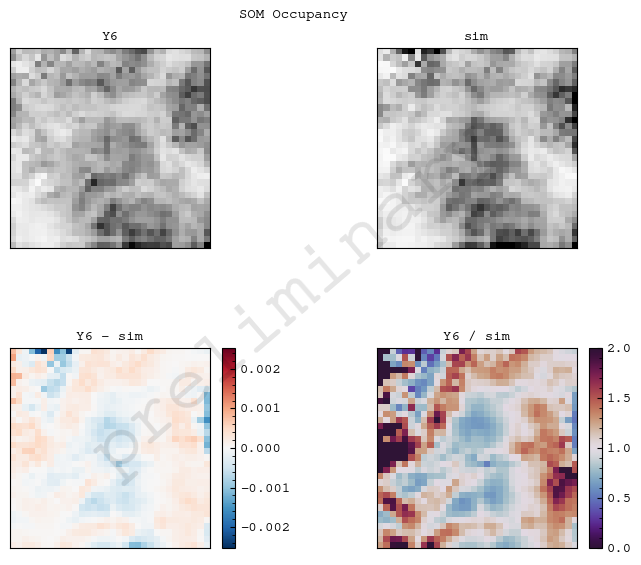

In [8]:
fig, axs = lib.plotting.make_axes(
    2, 2,
    **twocolumn_kwargs,
)

norm = mpl.colors.Normalize(vmin=0)
cmap = "binary"

diff_norm = mpl.colors.CenteredNorm(0)
diff_cmap = "RdBu_r"

ratio_norm = mpl.colors.CenteredNorm(1, 1)
ratio_cmap = "twilight_shifted"


im = axs[0, 0].imshow(
    som_occupancy_y6.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
    cmap=cmap,
)
axs[0, 0].set_title("Y6")

im = axs[0, 1].imshow(
    som_occupancy_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
    cmap=cmap,
)
axs[0, 1].set_title("sim")
# lib.plotting.add_colorbar(axs[0, 1], im)

im = axs[1, 0].imshow(
    occupancy_difference.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=diff_norm,
    cmap=diff_cmap,
)
axs[1, 0].set_title("Y6 - sim")
lib.plotting.add_colorbar(axs[1, 0], im)

im = axs[1, 1].imshow(
    occupancy_ratio.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=ratio_norm,
    cmap=ratio_cmap,
)
axs[1, 1].set_title("Y6 / sim")
lib.plotting.add_colorbar(axs[1, 1], im)

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])


fig.suptitle("SOM Occupancy")

lib.plotting.watermark(fig)

plt.show()

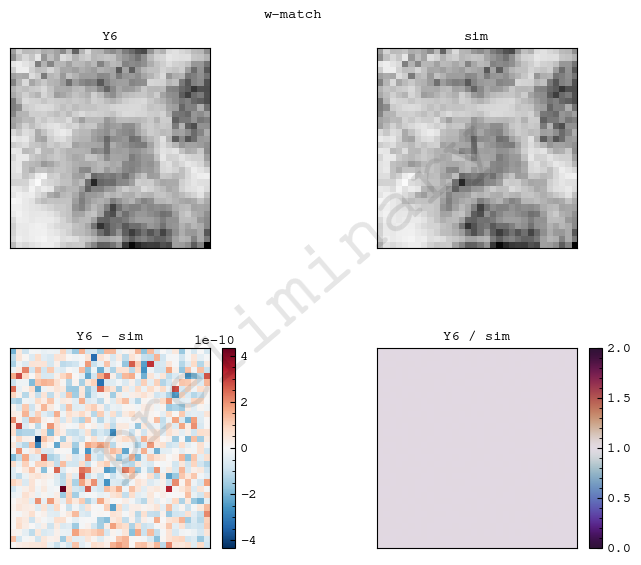

In [9]:
fig, axs = lib.plotting.make_axes(
    2, 2,
    **twocolumn_kwargs,
)

norm = mpl.colors.Normalize(vmin=0)
cmap = "binary"

diff_norm = mpl.colors.CenteredNorm(0)
diff_cmap = "RdBu_r"

ratio_norm = mpl.colors.CenteredNorm(1, 1)
ratio_cmap = "twilight_shifted"


im = axs[0, 0].imshow(
    som_occupancy_y6.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
    cmap=cmap,
)
axs[0, 0].set_title("Y6")

im = axs[0, 1].imshow(
    som_w_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
    cmap=cmap,
)
axs[0, 1].set_title("sim")
# lib.plotting.add_colorbar(axs[0, 1], im)

im = axs[1, 0].imshow(
    w_difference.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=diff_norm,
    cmap=diff_cmap,
)
axs[1, 0].set_title("Y6 - sim")
lib.plotting.add_colorbar(axs[1, 0], im)

im = axs[1, 1].imshow(
    w_ratio.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=ratio_norm,
    cmap=ratio_cmap,
)
axs[1, 1].set_title("Y6 / sim")
lib.plotting.add_colorbar(axs[1, 1], im)

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])


fig.suptitle("w-match")

lib.plotting.watermark(fig)

plt.show()

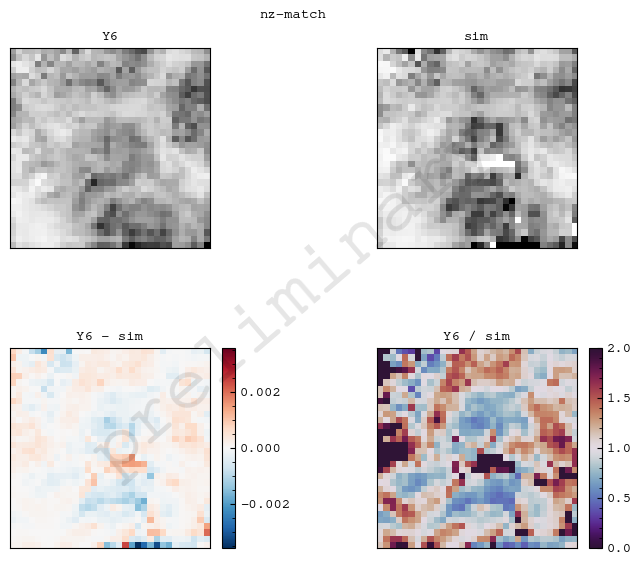

In [10]:
fig, axs = lib.plotting.make_axes(
    2, 2,
    **twocolumn_kwargs,
)

norm = mpl.colors.Normalize(vmin=0)
cmap = "binary"

diff_norm = mpl.colors.CenteredNorm(0)
diff_cmap = "RdBu_r"

ratio_norm = mpl.colors.CenteredNorm(1, 1)
ratio_cmap = "twilight_shifted"


im = axs[0, 0].imshow(
    som_occupancy_y6.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
    cmap=cmap,
)
axs[0, 0].set_title("Y6")

im = axs[0, 1].imshow(
    som_nz_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
    cmap=cmap,
)
axs[0, 1].set_title("sim")
# lib.plotting.add_colorbar(axs[0, 1], im)

im = axs[1, 0].imshow(
    nz_difference.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=diff_norm,
    cmap=diff_cmap,
)
axs[1, 0].set_title("Y6 - sim")
lib.plotting.add_colorbar(axs[1, 0], im)

im = axs[1, 1].imshow(
    nz_ratio.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=ratio_norm,
    cmap=ratio_cmap,
)
axs[1, 1].set_title("Y6 / sim")
lib.plotting.add_colorbar(axs[1, 1], im)

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])


fig.suptitle("nz-match")

lib.plotting.watermark(fig)

plt.show()

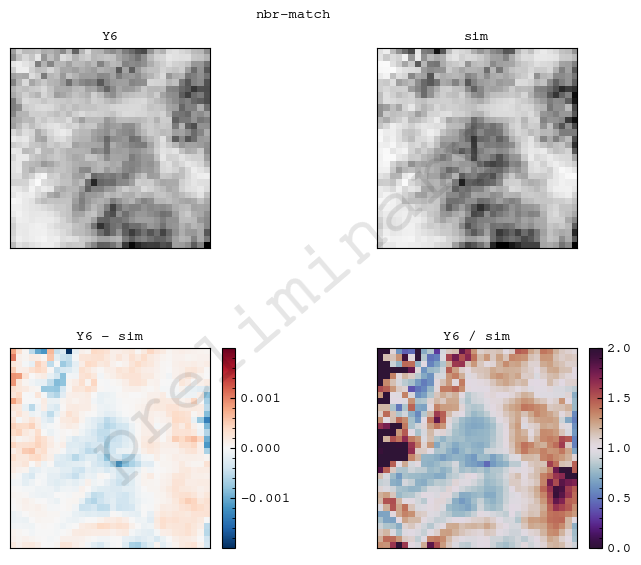

In [11]:
fig, axs = lib.plotting.make_axes(
    2, 2,
    **twocolumn_kwargs,
)

norm = mpl.colors.Normalize(vmin=0)
cmap = "binary"

diff_norm = mpl.colors.CenteredNorm(0)
diff_cmap = "RdBu_r"

ratio_norm = mpl.colors.CenteredNorm(1, 1)
ratio_cmap = "twilight_shifted"


im = axs[0, 0].imshow(
    som_occupancy_y6.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
    cmap=cmap,
)
axs[0, 0].set_title("Y6")

im = axs[0, 1].imshow(
    som_nbr_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
    cmap=cmap,
)
axs[0, 1].set_title("sim")
# lib.plotting.add_colorbar(axs[0, 1], im)

im = axs[1, 0].imshow(
    nbr_difference.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=diff_norm,
    cmap=diff_cmap,
)
axs[1, 0].set_title("Y6 - sim")
lib.plotting.add_colorbar(axs[1, 0], im)

im = axs[1, 1].imshow(
    nbr_ratio.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=ratio_norm,
    cmap=ratio_cmap,
)
axs[1, 1].set_title("Y6 / sim")
lib.plotting.add_colorbar(axs[1, 1], im)

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])


fig.suptitle("nbr-match")

lib.plotting.watermark(fig)

plt.show()

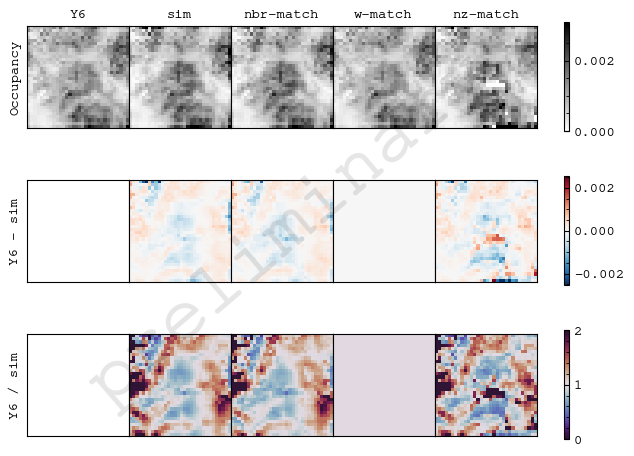

In [13]:
fig, axs = plt.subplots(3, 5, figsize=(7, 6), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

norm = mpl.colors.Normalize(vmin=0)
cmap = "binary"

diff_norm = mpl.colors.CenteredNorm(0)
diff_cmap = "RdBu_r"

ratio_norm = mpl.colors.CenteredNorm(1, 1)
ratio_cmap = "twilight_shifted"


im = axs[0, 0].imshow(
    som_occupancy_y6.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
    cmap=cmap,
)
im = axs[1, 0].imshow(
    np.zeros(lib.const.SOM_SHAPE),
    origin="lower",
    # norm=diff_norm,
    # cmap=diff_cmap,
)
im = axs[2, 0].imshow(
    np.ones(lib.const.SOM_SHAPE),
    origin="lower",
    # norm=ratio_norm,
    # cmap=ratio_cmap,
)
axs[0, 0].set_title("Y6")

im = axs[0, 1].imshow(
    som_occupancy_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
    cmap=cmap,
)
im = axs[1, 1].imshow(
    occupancy_difference.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=diff_norm,
    cmap=diff_cmap,
)
im = axs[2, 1].imshow(
    occupancy_ratio.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=ratio_norm,
    cmap=ratio_cmap,
)
axs[0, 1].set_title("sim")

im = axs[0, 2].imshow(
    som_nbr_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
    cmap=cmap,
)
im = axs[1, 2].imshow(
    nbr_difference.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=diff_norm,
    cmap=diff_cmap,
)
im = axs[2, 2].imshow(
    nbr_ratio.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=ratio_norm,
    cmap=ratio_cmap,
)
axs[0, 2].set_title("nbr-match")

im = axs[0, 3].imshow(
    som_w_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
    cmap=cmap,
)
im = axs[1, 3].imshow(
    w_difference.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=diff_norm,
    cmap=diff_cmap,
)
im = axs[2, 3].imshow(
    w_ratio.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=ratio_norm,
    cmap=ratio_cmap,
)
axs[0, 3].set_title("w-match")

im = axs[0, 4].imshow(
    som_nz_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
    cmap=cmap,
)
fig.colorbar(im, ax=axs[0, :], fraction=0.01)

im = axs[1, 4].imshow(
    nz_difference.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=diff_norm,
    cmap=diff_cmap,
)
fig.colorbar(im, ax=axs[1, :], fraction=0.01)

im = axs[2, 4].imshow(
    nz_ratio.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=ratio_norm,
    cmap=ratio_cmap,
)
fig.colorbar(im, ax=axs[2, :], fraction=0.01)

axs[0, 4].set_title("nz-match")

axs[0, 0].set_ylabel("Occupancy")
axs[1, 0].set_ylabel("Y6 - sim")
axs[2, 0].set_ylabel("Y6 / sim")

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])


lib.plotting.watermark(fig)

plt.savefig("occupancy.pdf")

plt.show()